<a href="https://colab.research.google.com/github/PrincyAjit/FoodNet_Files/blob/master/recipe_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inverse Cooking: Recipe Generation from Food Images



In [5]:
!git clone https://github.com/facebookresearch/inversecooking.git

fatal: destination path 'inversecooking' already exists and is not an empty directory.


In [6]:
!pip install -r /content/inversecooking/requirements.txt 

In [7]:
pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


In [8]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
!pip install torch==1.1.0 torchvision==0.3.0 #torch version 1.1.0 is required to get the right device which is cuda 0 with dtype Byte
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


  Using cached https://files.pythonhosted.org/packages/69/60/f685fb2cfb3088736bafbc9bdbb455327bdc8906b606da9c9a81bae1c81e/torch-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2e/45/0f2f3062c92d9cf1d5d7eabd3cae88cea9affbd2b17fb1c043627838cb0a/torchvision-0.3.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1
  Found existing installation: torchvision 0.2.1
    Uninstalling torchvision-0.2.1:
      Successfully uninstalled torchvision-0.2.1
5.3.0


In [9]:
%cd /content/inversecooking/src

/content/inversecooking/src


In [10]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

In [11]:
%cd /content/inversecooking/data
!wget https://dl.fbaipublicfiles.com/inversecooking/modelbest.ckpt
!wget https://dl.fbaipublicfiles.com/inversecooking/ingr_vocab.pkl
!wget https://dl.fbaipublicfiles.com/inversecooking/instr_vocab.pkl

/content/inversecooking/data
--2020-10-20 10:15:37--  https://dl.fbaipublicfiles.com/inversecooking/modelbest.ckpt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 415464764 (396M) [application/octet-stream]
Saving to: ‘modelbest.ckpt.2’

modelbest.ckpt.2    100%[===================>] 396.22M  12.1MB/s    in 34s     

2020-10-20 10:16:13 (11.6 MB/s) - ‘modelbest.ckpt.2’ saved [415464764/415464764]

--2020-10-20 10:16:13--  https://dl.fbaipublicfiles.com/inversecooking/ingr_vocab.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658 (30K) [application/octet-stream]
Saving to: 

In [12]:
%cd /content/inversecooking/src

/content/inversecooking/src


In [13]:
data_dir = '../data'

In [14]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [15]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [16]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [17]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 5.203873634338379


In [18]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [20]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

In [21]:
def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    #if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):
    if im.mode in ('RGBA', 'LA'):

        # Need to convert to RGBA if LA format due to a bug in PIL (http://stackoverflow.com/a/1963146)
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format
        # (http://stackoverflow.com/a/8720632  and  http://stackoverflow.com/a/9459208)
        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

In [22]:
#Delete The Sample Images if you want to use your own in the directory:

!rm /content/inversecooking/data/demo_imgs/*.jpg

rm: cannot remove '/content/inversecooking/data/demo_imgs/*.jpg': No such file or directory


In [23]:
import requests
from io import BytesIO
import random
from collections import Counter
import glob
from shutil import move

You should only need to re-run the cells below when you change images. 
If something does go wrong, usually a restart runtime fixes it.

In [24]:
#@title Images sources {"run": "auto"}

images_from = 'local fylesistem' #@param ["Demo URLs", "local fylesistem"]
use_urls = True if images_from == "Demo URLs" else False
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    #demo_imgs = os.listdir(image_folder)
    from google.colab import files
    uploaded = files.upload()
    
    for fn in uploaded.keys():
        print(fn)
        move(fn, image_folder + "/" + fn)
   
    
    demo_imgs = [os.path.basename(f) for f in glob.glob(image_folder + "/*.jpg")]
    demo_imgs = demo_imgs + [os.path.basename(f) for f in glob.glob(image_folder + "/*.jpeg")]
    demo_imgs = demo_imgs + [os.path.basename(f) for f in glob.glob(image_folder + "/*.png")]
   
    #random.shuffle(demo_imgs)

demo_urls = ['http://images.media-allrecipes.com/userphotos/960x960/5544320.jpg',
            'https://i.kym-cdn.com/photos/images/newsfeed/001/504/739/5c0.jpg',
            'https://cdn.pixabay.com/photo/2015/07/11/08/59/moon-840635_960_720.png',
            'https://upload.wikimedia.org/wikipedia/commons/5/56/Donald_Trump_official_portrait.jpg',
            'https://images-na.ssl-images-amazon.com/images/I/71lnQdxlWzL._SL1500_.jpg']

demo_files = demo_urls if use_urls else demo_imgs

Saving images (1).jpeg to images (1).jpeg
images (1).jpeg


In [25]:
print("Images to be Reciped: " + str(demo_files))

Images to be Reciped: ['images (1).jpeg']


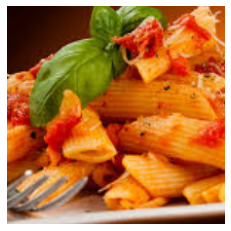

RECIPE 1

Title: Pasta with fresh tomato sauce

Ingredients:
pasta, cheese, basil, pepper, tomato, oil

Instructions:
-Cook pasta as directed on package, omitting salt.
-Meanwhile, heat oil in large skillet on medium heat.
-Add tomatoes; cook and stir 5 min.
-Or until heated through.
-Drain pasta.
-Add to tomato mixture along with the basil and cheese; mix lightly.
RECIPE 2

Title: 20-minute one-pot pasta primavera

Ingredients:
pasta, cheese, basil, pepper, tomato, oil

Instructions:
-Heat olive oil in large nonstick skillet on medium-high heat.
-Add peppers; cook and stir 3 to 5 min.
-Or until crisp-tender.
-Stir in rotini; cook 4 min.
-Or until heated through.
-Add tomatoes; mix lightly.
-Sprinkle with cheese.
-Cook 1 min.
-Or until cheese is completely melted and mixture is heated through, stirring occasionally.
RECIPE 3

Title: Pasta with tomato & basil

Ingredients:
pasta, cheese, basil, pepper, tomato, oil

Instructions:
-Cook pasta in large saucepan as directed on package, omit

In [26]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path)
    
    #print(image.mode)
    if image.mode != 'RGB':
        #If you just convert to RGB, sometimes the background ends up black, though I'm not sure if it effects the model
        image = remove_transparency(image)
        image = image.convert('RGB')
   
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i],temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])
        